# Application of Gradient Boosting Machine and Neural Networks to Predict Patient Cancer Survival with Gene Mutation Data and Clinical Survival Data

## Version: Breast Cancer

###  Washieu Anan

#### Breast cancer survival data from the TCGA holds clues as to what genetic mutations may cause the ultimate fate of patients. In this study, we perform standard survival analysis using  Kaplan Meir Fitter Survival and COX Proportional Hazards, and finally use a gradient boosting model to see if we can predict survival of a patient based on their mutations. Two neural networks will also be applied to determine if neural networks are good classifiers for survival predictions. 

#### IMPORTANT NOTE: This notebook is solely for breast cancer data. For skin cancer data, please refer to the other notebook linked.

## Loading Data from Genomic Data Commons

The National Cancer Institute runs the Genomic Data Commons (GDC), an extremely thorough repository of genomic and clinical data. This is an indispensable data repository for scientists and offers multiple data formats depending on a study of interest. There are many ways to download data from the GDC.

   1. Download directly from the GDC portal. This is perhaps the easiest way to download data as the website interface is very simple, has many filters to help find data quickly, and is also a good way to visualize data. However, for the purpose of demonstrating how data can be downloaded programmatically, this method will not be employed (except to download the clinical .tar file first). Additionally, in the case of downloading multiple datasets, using the website interface can be tedious. 
   2. Using the GDC client. The GDC has a data download tool that can download multiple datasets if one has a manifest file. A manifest file can be downloaded from the GDC portal after selecting what cancer types, file types, and other features one desires. This is very useful if someone wants to download many clinical and mutation files. 
   3. Using the GDC API. The GDC has built an API that can be used with Python to download any file. The file is downloaded onto the user's computer. The user can then access the file from their computer and load it into a kernel.
    
The method that will be used is (3), the GDC API. Since only 2 cancer types will be examined for the purpose of this project, the API is a good way to download data programmatically. In order to download desired data, UUIDs will be required. A UUID is a special identification number for any file on the GDC repository. This number can be accessed once clicking on a file on the GDC portal. It can also be accessed from a manifest file if one is to download multiple datasets at a time. 

For this project, we will examine two cancer types: Breast and Skin. For each of these cancer types, we will use data collected by the Cancer Genome Atlas project (TCGA). TCGA data is very thorough is used by many bioinformaticians. There are two file types will require for survival analysis and survival prediction: clinical and mutation. The purpose of and data in each file is as follows:

   1. Clinical: clinical files have patient ids (unique alpha-numeric identification key), some patient information like date of birth, vital status (whether patient is alive or dead), days since last follow up or diagnosis, information regarding cancer cells, cancer stage, and information about some possibly related diseases. Many of these files are closed access and can only be obtained if one is given special permission by the NIC. We will only be using open access data. This file does not contain patient's names or locations.

   2. Mutation file: mutation files contain information regarding mutated genes collected from the same patients listed in clinical files. These files have the same patient ids as in clinical files, but focus on mutated genes, site of mutation, type of mutation, region of mutation, and impact of mutation. These datasets are fairly large and contain information regarding some non-relevant mutations. Therefore, some filtering will be employed to only use mutation information for the most prevalent and high impact mutations. 
   
Clinical files can only be retrieved through the portal or by using the GDC client tool. For the purpose of this project, the GDC portal will be used for downloading the clinical files. The mutation files will be downloaded using the API.

In [1]:
'''Import libraries'''

#Essential 
import numpy as np
import requests
import json
import re
import tarfile
import pandas as pd #pandas will help as visualize data
import seaborn as sns #for exploratory data visualization
from matplotlib import pyplot as plt


#Lifelines is a very helpful API for survival analysis. This will help make survival curves.
from lifelines import KaplanMeierFitter
from lifelines import ExponentialFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter

#Machine learning Models
import xgboost as xgb #Gradient Boosting Machine
from sklearn.neural_network import MLPClassifier #Multi-Layer Perceptron 
from keras.models import Sequential #Neural Network
from keras.layers import Dense
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder #for encoding of categorical data

Using TensorFlow backend.


##### Clinical Files

In [2]:
'''Clinical files are stored in .tar files by the GDC. The .tar file needs to be extracted to access the CSV file inside. 
Ensure that .tar files from the GDC are in the same working directory. Each .tar file contains a file named 'clinical.tsv' and
a file named 'exposure.tsv'. Thus, it is important to store each file into a seperate dataframe immediately after untarring.
This will ensure the data for different cancer types don't get mixed up or replace each other.'''


#Breast Cancer Clinical File
#Untarring
breast_tar = tarfile.open("breast_clinical.cases_selection.tar.gz")
breast_tar.extractall()
breast_tar.close()

#Store in dataframe for breast cancer
clinical_file = 'clinical.tsv'
df_breast = pd.read_csv(clinical_file, sep='\t')


In [3]:
df_breast.head(3) #Verify that breast clinical data is stored successfully

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,...,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,TCGA-AR-A24X,TCGA-BRCA,--,female,1954,white,-19030,alive,--,...,--,--,--,--,"Breast, NOS",--,--,--,--,--
1,31427699-e27a-4035-8925-6d8d6900d097,TCGA-E2-A3DX,TCGA-BRCA,--,female,1968,white,-15969,alive,--,...,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,6cb6f179-defd-4661-af0a-c353b74c0c49,TCGA-A7-A26J,TCGA-BRCA,--,female,1962,white,-17930,alive,--,...,--,--,--,--,"Breast, NOS",--,--,--,--,--


The breast and skin cancer data has been successfully stored in their own respective dataframes. This is clear as indicated by the 'project_id' field in both dataframes shown above. 'TCGA-BRCA' stands for TCGA breast cancer and 'TCGA-SKCM' stands for TCGA skin cancer.

##### Mutation Files

In [5]:
'''Using the GDC's API as well as UUID names for TCGA breast and skin cancer mutation files, mutation data is stored in
the same directory location as this file.'''

pd.set_option('display.max_columns', None) #To see all columns of files in dataframe

#Load Breast Cancer Data   
#Breast Cancer Mutation File
breast_mut_file_id = "995c0111-d90b-4140-bee7-3845436c3b42"
data_endpt = "https://api.gdc.cancer.gov/data/{}".format(breast_mut_file_id)
response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})

# The file name can be found in the header within the Content-Disposition key.
response_head_cd = response.headers["Content-Disposition"]
file_name = re.findall("filename=(.+)", response_head_cd)[0]
with open(file_name, "wb") as output_file:
    output_file.write(response.content)

#Store in pandas dataframe
breast_maf = pd.read_table(file_name, comment='#')    
#Filter the mutation data to get the most prevelant mutations
breast_mut = breast_maf[(breast_maf.FILTER == "PASS") & ((breast_maf.IMPACT == "MODERATE") | (breast_maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria for breast cancer, {:.2f}%".format(
    len(breast_mut), len(breast_maf), 100 * len(breast_mut) / len(breast_maf)))

In [6]:
breast_mut.head(3) #Verify that breast cancer mutation dataset is stored

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
1,ERICH3,127254,WUGSC,GRCh38,chr1,74571494,74571494,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4216G>A,p.Glu1406Lys,p.E1406K,ENST00000326665,14/15,86,42,44,64,NaN,NaN,"ERICH3,missense_variant,p.E1406K,ENST000003266...",T,ENSG00000178965,ENST00000326665,Transcript,missense_variant,missense_variant,4435/7159,4216/4593,1406/1530,E/K,Gag/Aag,NaN,1,NaN,-1.0,ERICH3,HGNC,HGNC:25346,protein_coding,YES,CCDS30755.1,ENSP00000322609,Q5RHP9,NaN,UPI0000237200,NM_001002912.4,deleterious(0.01),possibly_damaging(0.833),14/15,NaN,PROSITE_profiles:PS50313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TTCCTCTACCA,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1474194,True,Unknown
6,FN1,2335,WUGSC,GRCh38,chr2,215397809,215397809,+,Nonsense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.3388G>T,p.Glu1130Ter,p.E1130*,ENST00000359671,22/45,94,77,17,106,NaN,NaN,"FN1,stop_gained,p.E1130*,ENST00000354785,NM_21...",A,ENSG00000115414,ENST00000359671,Transcript,stop_gained,stop_gained,3654/8524,3388/7161,1130/2386,E/*,Gaa/Taa,NaN,1,NaN,-1.0,FN1,HGNC,HGNC:3778,protein_coding,NaN,NaN,ENSP00000352696,P02751,NaN,UPI00001AEBF3,NaN,NaN,NaN,22/45,NaN,Pfam_domain:PF00041;PROSITE_profiles:PS50853;S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIGH,NaN,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CACTTCTCGTG,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1482746;COSM1482747,True,Unknown
7,SPHKAP,80309,WUGSC,GRCh38,chr2,228016738,228016738,+,Missense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4116G>T,p.Arg1372Ser,p.R1372S,ENST00000392056,7/12,74,61,13,61,NaN,NaN,"SPHKAP,missense_variant,p.R1372S,ENST000003920...

In [7]:
skin_mut.head(3) #Verify that skin cancer mutation dataset is stored. 

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
0,CAMTA1,23261,BI,GRCh38,chr1,7663407,7663407,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.860C>T,p.Ser287Leu,p.S287L,ENST00000303635,9/23,129,97,32,113,NaN,NaN,"CAMTA1,missense_variant,p.S287L,ENST0000030363...",T,ENSG00000171735,ENST00000303635,Transcript,missense_variant,missense_variant,1067/8444,860/5022,287/1673,S/L,tCg/tTg,NaN,1,NaN,1.0,CAMTA1,HGNC,HGNC:18806,protein_coding,YES,CCDS30576.1,ENSP00000306522,Q9Y6Y1,NaN,UPI00001C1D72,NM_015215.3,deleterious(0),probably_damaging(0.99),9/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CATCTCGCCCA,f944eaa8-8260-411c-b875-824f27ab961c,e0e25c3a-0f0c-4d60-b1d5-9938d3e1c4d0,4ba835c3-36e8-4285-bffc-187fa3c048cb,69c0ef46-3117-46f3-b36e-581eb03eb829,NaN,COSM43045,True,Unknown
1,C8B,732,BI,GRCh38,chr1,56956798,56956798,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.362G>A,p.Arg121Gln,p.R121Q,ENST00000371237,3/12,315,242,73,371,NaN,NaN,"C8B,missense_variant,p.R69Q,ENST00000543257,NM...",T,ENSG00000021852,ENST00000371237,Transcript,missense_variant,missense_variant,429/2037,362/1776,121/591,R/Q,cGa/cAa,NaN,1,NaN,-1.0,C8B,HGNC,HGNC:1353,protein_coding,YES,CCDS30730.1,ENSP00000360281,P07358,NaN,UPI000013C9B2,NM_000066.3,tolerated(0.13),benign(0.022),3/12,NaN,PROSITE_profiles:PS50068;SMART_domains:SM00192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CACATCGCACT,f944eaa8-8260-411c-b875-824f27ab961c,e0e25c3a-0f0c-4d60-b1d5-9938d3e1c4d0,4ba835c3-36e8-4285-bffc-187fa3c048cb,69c0ef46-3117-46f3-b36e-581eb03eb829,NaN,COSM3491224,True,Unknown
3,ARHGAP29,9411,BI,GRCh38,chr1,94188873,94188873,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.1645G>A,p.Glu549Lys,p.E549K,ENST00000260526,15/23,113,81,32,117,NaN,NaN,"ARHGAP29,missense_variant,p.E549K,ENST00000260...",T,ENSG0000013796

All data has been successfully downloaded and stored into seperate, unique dataframes. This proves that clinical and mutation data available on the GDC can be programatically downloaded (with the exception of having to physically download the clinical .tar file from the GDC portal or by using the GDC client). Additionally, the mutation dataset was filtered to find the most prevelant mutations in the list. 

## Breast Cancer Survival Analysis 

The breast cancer data will be studied first. Survival analysis will allow us to see how gene mutations and cancer stage ultimately impact survival of a patient over time. 

In [8]:
'''
Since, we are dealing with breast cancer, we should really focus on the TP53 and PIK3CA genes. We can find the mutation 
load of each gene and we will see that the TP53 and PIK3CA genehave the highest load. Within the breast_mut dataframe, 
one can find many column names. Here are some very relevant ones

Hugo_Symbol: name of the gene

Entrez_Gene_id: id of the gene, similar to Hugo_Symbol

case_id: patient case id associated with patients in the clinical file; this will allow us to merge the mutations and clinical
dataframes for each unique patient

Tumor_Sample_Barcode: unique barcode for the dataset
'''

#Let's show the frequency of each unique mutation in our mutation dataset
mutation_frequency_breast = breast_mut.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_breast.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_breast.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14207,TP53,325
10175,PIK3CA,323
14595,TTN,184
2338,CDH1,132
5145,GATA3,129
8415,MUC16,111
7076,KMT2C,90
7760,MAP3K1,79
11836,RYR2,63
5967,HMCN1,61


As we can see, the TP53 and PIK3CA genes are the most prevenlently mutated genes associated with breast cancer. Thus, our focus will be on these genes. The importance of the genes in breast cancer has been shown in cancer studies as well. G et al. in "Prevalence and spectrum of AKT1, PIK3CA, PTEN and TP53 somatic mutations in Chinese breast cancer patients" discusses these two genes with regards to their impact on breast cancer in depth [1].

In [9]:
'''Not every column in the mutation dataframe is relevant to us. We care about the mutation name and id, as well as the
case id of the patient that mutation. This is because want to see the impact of the gene mutation itself on patient survival
time. Other features can be used from this mutation dataset for future studies.'''

#Let's take parts of the mutation set that are most relevant going forward. Let's store it in a new dataframe called relmut
breast_relmut = breast_mut[['Hugo_Symbol', 'Entrez_Gene_Id', 'case_id', 'Tumor_Sample_Barcode']]
breast_relmut.head()

,Hugo_Symbol,Entrez_Gene_Id,case_id,Tumor_Sample_Barcode
1,ERICH3,127254,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
6,FN1,2335,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
7,SPHKAP,80309,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
8,HRH1,3269,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
11,PIK3CA,5290,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09


In [10]:
'''Now, lets move onto understanding the clinical file. However, we want to make sure that we analyze patient data for patients
who also show up in the mutation dataset. Otherwise, we may have missing values in some columns for some patients. This may occur
due to our filtering of the mutation dataset for high impact mutations.'''

#You will notice that there are case ids in this mutation file. These case ids correspond to the case ids in our clinical file.
#We want to find the instances in our clinical file that are also part of the mutation file.
cID = breast_relmut.case_id.tolist() #let's store the case ids inside a list
df_breast = df_breast[df_breast['case_id'].isin(cID)] #Now let's filter our clinical file dataframe with the case ids also in relmut
df_breast.head()

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,tumor_largest_dimension_diameter,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,ajcc_staging_system_edition,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,TCGA-AR-A24X,TCGA-BRCA,--,female,1954,white,-19030,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,Infiltrating duct and lobular carcinoma,stage iia,19030,--,8522/3,--,--,--,--,--,--,--,--,--,--,--,3004,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,6cb6f179-defd-4661-af0a-c353b74c0c49,TCGA-A7-A26J,TCGA-BRCA,--,female,1962,white,-17930,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,17930,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,627,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,TCGA-OL-A5RU,TCGA-BRCA,--,female,1947,black or african american,-23108,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,23108,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,1219,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
5,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,TCGA-BRCA,--,female,1941,white,-24999,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage i,24999,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,591,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
6,8631969d-4ac6-4fe1-9db3-d47db604494a,TCGA-E9-A1R2,TCGA-BRCA,--,female,1960,white,-18936,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iiic,18936,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,1063,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--


You may notice many columns have missing values or are simply not reported. For suvival analysis, we only really need two pieces of information:

1. Vital status: we need to know if the patient is alive or dead at the conclusion of this study in which this data was collected. 
2. Cancer duration: this is the amount of time that has passed from cancer diagnosis to death ('days_to_death' column) or the amount of time that has passed from the most recent followup appointment ('days_to_last_follow_up' column). We need to consolidate these columns into one 'duration' column. 
3. Tumor stage: since the stage of the tumor at the end of the study is of interest to us for the machine learning portion of the project in which survival prediction will be done, we need to extract that infomration as well.

In [11]:
#As shown in the pandas dataframe for the clinical file, we have multiple fields of information for each patient sample. 
#However, we are particularly interested in the days to death or days to last follow up and the vital status of the patients.
#When we have found those particular fields and isolated them, we can begin to modify the table by simplifying the 
#vital status for the use of survival regression studies.

#Let's modify the data set to only have the particular columns we want
df_breast_1 = df_breast[['case_id', 'vital_status', 'days_to_death', 'days_to_last_follow_up', 'tumor_stage']]
df_breast_1.head()

,case_id,vital_status,days_to_death,days_to_last_follow_up,tumor_stage
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,alive,--,3004,stage iia
2,6cb6f179-defd-4661-af0a-c353b74c0c49,alive,--,627,stage iia
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,alive,--,1219,stage iia
5,24e39609-9645-43e5-960b-db5446eaea65,alive,--,591,stage i
6,8631969d-4ac6-4fe1-9db3-d47db604494a,alive,--,1063,stage iiic


In [12]:
#Examine how many patients will be studied
print('Total patients in dataset: ' + str(len(df_breast_1)))

Total patients in dataset: 985


In [4]:
#The days_to_death and days_to_last_follow_up column is our duration information. We want to consolidate that information
#into one duration set. Using pandas column manipulation, we can do just that. Additionally, we should set the vital_status info
#into integers based on dead or alive status. Alive will be a 0, while dead will be a 1.

df2 = df_breast_1 #We want to modify the table but without tampering with it
df2.days_to_death[df2.days_to_death == '--'] = df2.days_to_last_follow_up #Get rid of empty rows in the days_to_death column
df2['duration'] = df2['days_to_death'] #copy all values into one duration column
df3 = df2[['case_id','vital_status', 'duration', 'tumor_stage']] #df3 is the dataframe with our ultimate data
df3.vital_status[df3.vital_status == 'alive'] = 0 #making vital_status into 0 or 1 based on status
df3.vital_status[df3.vital_status == 'dead'] = 1
df3 = df3[df3['duration'] != '--'] #Takes care of any missing duration rows

In [14]:
#The duration and vital_status needs to be converted to a numeric for further use
df3['duration'] = pd.to_numeric(df3['duration'])
df3['vital_status'] = pd.to_numeric(df3['vital_status'])
df3.head()

,case_id,vital_status,duration,tumor_stage
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia
2,6cb6f179-defd-4661-af0a-c353b74c0c49,0,627,stage iia
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,0,1219,stage iia
5,24e39609-9645-43e5-960b-db5446eaea65,0,591,stage i
6,8631969d-4ac6-4fe1-9db3-d47db604494a,0,1063,stage iiic


As shown above, the 'duration' field is a consolidated patient survival duration column. This will allow for a simple survival analysis. However, we are interested in survival analysis for patients based on their gene mutation as well. Thus, we will need to now merge the mutation and clinical dataframes.

In [15]:
#We can now find the intersection between the mutation dataset and the clinical file by merging the two based 
#on the case_id field. 
df3 = pd.merge(df3, breast_relmut, on='case_id', how='inner')
df3.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,ARID1A,8289,TCGA-AR-A24X-01A-11D-A167-09
1,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,MAST2,23139,TCGA-AR-A24X-01A-11D-A167-09
2,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,PLEKHH2,130271,TCGA-AR-A24X-01A-11D-A167-09
3,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,ACPP,55,TCGA-AR-A24X-01A-11D-A167-09
4,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,SI,6476,TCGA-AR-A24X-01A-11D-A167-09


In [16]:
#Let us confirm using the mutation frequency that the most common genes we should worry about are TP53 and PIK3CA, just
#this time with our combined dataframe with muatation info, duration, and vital_status. As you can see, those two genes
#are still most prevalent.
mutation_frequency_breast = df3.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_breast.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_breast.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14207,TP53,325
10175,PIK3CA,323
14595,TTN,184
2338,CDH1,132
5145,GATA3,129
8415,MUC16,111
7076,KMT2C,89
7760,MAP3K1,79
11836,RYR2,63
5967,HMCN1,61


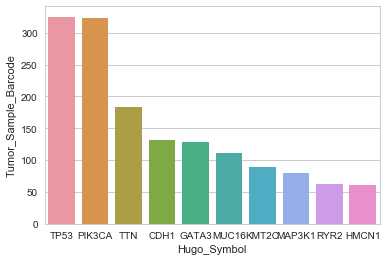

In [17]:
#Let's visualize this to showcase how important each gene probably is compared to other genes in the top 10 most prevelant genes
sns.set(style="whitegrid")
sns.barplot(x = 'Hugo_Symbol', y = 'Tumor_Sample_Barcode', data = mutation_frequency_breast[0:10])

In [18]:
#Just as an extra check, we can even see if those two genes are common amongst patients who passed away.
df3_test_one = df3[df3['vital_status'] == 1]
mutation_frequency_test_one = df3_test_one.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_test_one.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_test_one.head()

,Hugo_Symbol,Tumor_Sample_Barcode
6170,TP53,51
4414,PIK3CA,42
6320,TTN,28
2227,GATA3,20
3081,KMT2C,18


In [19]:
#Since we can see that the TP53 and PIK3CA genes are the most important genes for breast cancer status, let's filter our
#combined clinical/mutation dataset for cases with these mutations. However, we want to see how a less prevelant gene
#affects patient survival as well so as to highlight the biffer effect of the TP53 and PIK3CA genes on breast cancer patient 
#survival. Thus, let's pick the 10th most prevelant gene in our filtered dataset: HMCN1
common = ['TP53', 'PIK3CA', 'HMCN1'] #store the important genes in a list
df3 = df3[df3['Hugo_Symbol'].isin(common)] #filter the dataframe with the two genes inside the list common
df3.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
83,24e39609-9645-43e5-960b-db5446eaea65,0,591,stage i,PIK3CA,5290,TCGA-E2-A154-01A-11D-A10Y-09
343,a6edb6ca-ae9f-4da7-8ebe-92d83d2987fb,0,450,stage iia,TP53,7157,TCGA-E2-A158-01A-11D-A12B-09
368,491b6364-1223-474f-816f-e248c8c841e2,0,1156,stage iib,HMCN1,83872,TCGA-BH-A0DH-01A-11D-A099-09
408,298a1710-deb4-4064-a0f2-da32d43aa217,0,1476,stage iib,PIK3CA,5290,TCGA-C8-A12Y-01A-11D-A12B-09
486,4fba3deb-db94-44b5-a0f2-a575d270779e,0,1174,stage iia,HMCN1,83872,TCGA-E2-A14R-01A-11D-A10Y-09


In [20]:
#Let's see how many patienst we will be studying
print('Patients in analysis: ' + str(len(df3)))

Patients in analysis: 758


In [7]:
#Let us see the distribruation of the duration
durationsxx = df3['duration']
sns.distplot(durationsxx).set_title('Breast Cancer Patient Survival Duration Distriburtion')

### Plotting Survival Curves

Now, we can begin plotting survival curves. These curves shows the fractions of patients alive as time passes onto the end of the study. We need to understand something important about our data first, however. In our dataset, we don't know exactly when the patients actually started having cancer. We know how long it has been since they have been diagnosed with cancer and the amount of time to the end of the study or to their death. Thus, our data is known to be left censored. This is an important consideration to take into account when making survival curves and hazard curves.

Additionally, it is important to realize that for every gene mutation, we may not see survival curves for each mutation of interest complete to the end of total duration. For example, the survival curve for one mutation may end abruptly before the end of the study period. This is either because no more patients with that particular died after a certain point in the study or patient data for patients with that gene mutation stopped being collected.

Text(0, 0.5, 'Fraction of Patients Alive')

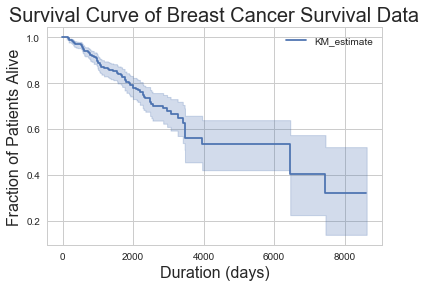

In [22]:
'''We can start performing survival analysis. We can use the Kaplan-Meier Estimate from the liflines module.
We can also find the cumulative density function of our dataset based on the two important genes.'''

#Let's make a Kaplan Meier Fitter Survival curve for the entire data set
T = df3['duration'] #we store the duration information in the dataframe T
E = df3['vital_status'] #we store the vital_status information in the dataframe E

#We will pass these dataframes to the Kaplan-Meier Estimate fitter
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  
kmf.survival_function_
kmf.median_
kmf.plot()
plt.title('Survival Curve of Breast Cancer Survival Data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0, 0.5, 'Fraction of Patients Alive')

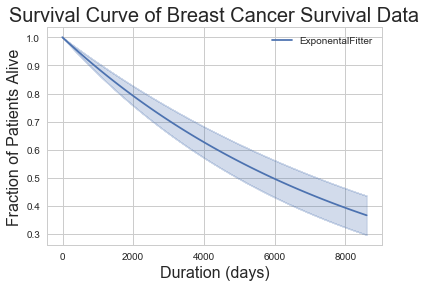

In [23]:
#We can also fit our survival curve to an exponential model. This is much smoother than the KM estimate. 
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, E, label='ExponentalFitter')
ax = exf.plot()
plt.title('Survival Curve of Breast Cancer Survival Data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0, 0.5, 'Fraction of Patients Alive')

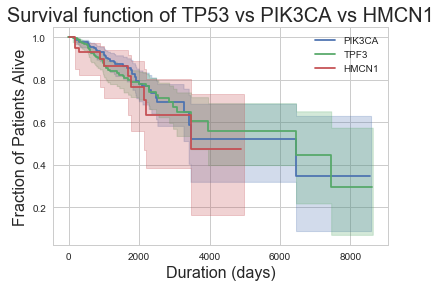

In [24]:
#Now lets plot the KMF survival curves per mutated gene. We will go ahead and plot the survival curve for each mutated gene
#and also compare them in one survival graph.
groups = df3['Hugo_Symbol'] #groups is a dataframe with the gene names

#Make the survival curve comparing TP53 gene against PIK3CA
tp53 = (groups == 'TP53')
pik = (groups == 'PIK3CA')
hmc = (groups == 'HMCN1')

kmf.fit(T[pik], E[pik], label='PIK3CA')
ax = kmf.plot()
kmf.fit(T[tp53], E[tp53], label='TPF3')
ax = kmf.plot(ax=ax)
kmf.fit(T[hmc], E[hmc], label='HMCN1')
ax = kmf.plot(ax=ax)
plt.title('Survival function of TP53 vs PIK3CA vs HMCN1', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

This is a clear example of what to expect with left censored data! As we can see, patients with the HMCN1 mutation show a survival curve that abruptly ends before the two other gene mutations. This may mean that no more patients with the HMCN1 gene mutation died or that data for patients with that gene mutation were no longer being checked on by those who collected this data.

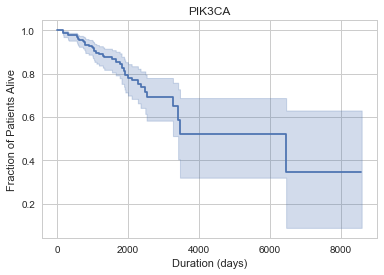

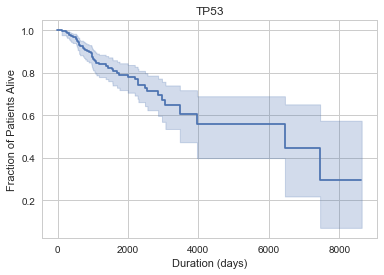

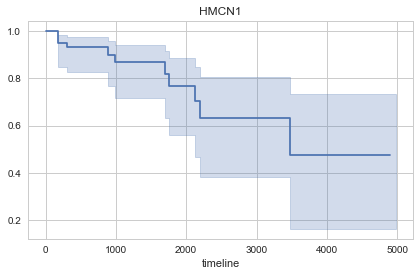

In [25]:
#We can also visualize them seperately.
mutgenes = df3['Hugo_Symbol'].unique()

for i,mg in enumerate(mutgenes):
 
    ix = df3['Hugo_Symbol'] == mg
    kmf.fit( T[ix], E[ix], label=mg)
    kmf.plot(legend=False)
    plt.title(mg)
    if i==0:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
    elif i==1:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
plt.tight_layout()

### Plotting Hazard Curves

Now let us plot the cumulative density function for our data set. This is the hazard function of our dataset, displaying the hazard or chance of death as time goes on. We don't witness the onset of the cancer, we only know how longthe patient has been alive or dead, so this is a good estimate of the hazard.

As can be seen below, as time passes on, the hazard of death, or the chance of death significantly rises.

Text(0.5, 1.0, 'Cumulative Density Function/Hazard Curve')

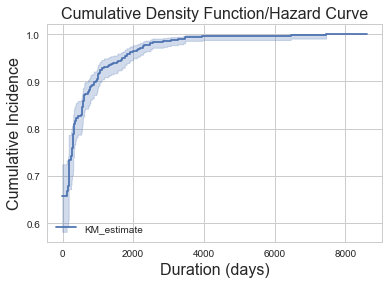

In [26]:
#Kaplan Meier Fitter plots hazard functions for survival studies if we input that left_censorship=True
kmf = KaplanMeierFitter()
kmf.fit(T, E, left_censorship=True)
kmf.plot() #will plot the CDF
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)
plt.title("Cumulative Density Function/Hazard Curve", fontsize=16)

Text(0, 0.5, 'Cumulative Incidence')

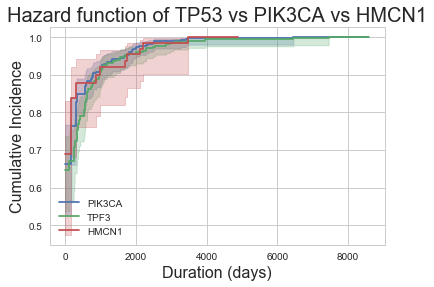

In [27]:
kmf.fit(T[pik], E[pik], label='PIK3CA',left_censorship=True)
ax = kmf.plot()
kmf.fit(T[tp53], E[tp53], label='TPF3', left_censorship=True)
ax = kmf.plot(ax=ax)
kmf.fit(T[hmc], E[hmc], label='HMCN1', left_censorship=True)
ax = kmf.plot(ax=ax)
plt.title('Hazard function of TP53 vs PIK3CA vs HMCN1', fontsize=20)
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)

As we can see, the three genes seem to show similar hazard curves. However, notice that the error for the HMCN1 curve is much larger than that of PIK3CA and TP53. This is probably because HMCN1's effect on patient survival varies much more greatly from patient to patient. Also notice, the curve end abruptly. It is interesting that the hazard functions are similar for all three gene mutations. This suggests that although TP53 and PIK3CA are the most prevelant gene mutations in patients with breast cancer, they aren't necessarily the most important gene mutation leading to death for every patient. This hazard curve may suggest that the HMCN1 gene mutation may actually have as much of an effect on breast cancer patient survival as PIK3CA and TP53!  Interestingly, Kikutake et al., in "Intratumor heterogeneity of HMCN1 mutant alleles associated with poor prognosis in patients with breast cancer" identified that the HMCN1 gene may be very important for breast cancer cell metastisis and may be a good candidate for breast cancer therapy [2].

Thus, our survival analysis has allowed us to see the effects of three mutated genes on breast cancer patient survival. We knew that the PIK3CA and TP53 gene mutations are most prevalent. However, our analysis showed us that the much less prevelant mutation HMCN1 may also be of importance. Therefore, it important to also further study the effect of the HMCN1 gene mutation on breast cancer. We were able to use patient clinical data and mutation data to come to this important conclusion.


In [28]:
'''In this section, we apply a COX regression model to see if there is an assocation with survival
time of patients and their mutated gene.'''

#COX Regression Analysis
from lifelines import CoxPHFitter
df4 = df3[['Entrez_Gene_Id', 'duration', 'vital_status']]
cph = CoxPHFitter()
cph.fit(df4, duration_col='duration', event_col='vital_status', show_progress=True)

cph.print_summary()  #results


Iteration 1: norm_delta = 0.06869, step_size = 0.95000, ll = -586.44180, newton_decrement = 0.24964, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00259, step_size = 0.95000, ll = -586.20771, newton_decrement = 0.00043, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00014, step_size = 0.95000, ll = -586.20728, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 3 iterations.
<lifelines.CoxPHFitter: fitted with 758 observations, 651 censored>
      duration col = duration
         event col = vital_status
number of subjects = 758
  number of events = 107
    log-likelihood = -586.207
  time fit was run = 2019-05-17 22:17:44 UTC

---
                 coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95   
Entrez_Gene_Id 0.0000     1.0000    0.0000 0.7054 0.4806     -0.0000      0.0000   
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.541
Likelihood ratio test = 0.469 on 1 df, p=0.49343


As can be seen, the p value is really high. The concordance is also close to .5. This means that regardless of the TP53, PIK3CA, or HMCN1 gene mutation, one generally has a random chance of determining the survival status of the breast cancer patient. This is in agreement with the conclusions we made earlier using curvival and hazard curves.

## Machine Learning: Breast Cancer Survival Prediction

Now, we will make a few machine learning models to predict breast cancer patient survival. The purpose of this study is to determine if we can use patient tumor stage, duration, and gene mutation type to predict vital status. The value of this study is that it allows for us to determine whether or not a patient is expected to survive given their tumor stage and gene mutation. This is very important in clinical settings because it may ultimately impact the administration of life saving medications and save lives. 

Note: Since we want to determine patient survival, we are dealing with a classification problem and not a regression one. 

Three kinds of machine learning approaches will be utilized:

1. Gradient Boosting Machine: a gradient boosting machine is a decision tree based alogorithm that can be used for classification or regression purposes. Using decision trees, the model constantly adjusts predictions in order to minimize loss determined by the inputted loss function. This model is very powerful as it doesn't just fit data to a model, it also constantly updates the model using gradient descent. This is a supervised learning approach. 

2. Multilayer Perceptron: scikit-learn offers its own version of a built in neural network called MLPClassifier. It is similar to the neural network, but it is worth seeing if it can outperform the neural network made with keras. Using GridSearchCV will also help determine the best paramters for the neural network made with Keras (below).

3. Neural Network with Keras: a neural network has many layers that will approximate weights for the inputted data to ultimately reach a conclusion. The weights will be updated overtime to fit the data to the proper classifications. Neural networks can be made with any number of layers, and the ideal model varies from use case to use case. In this case, we will be doing supervised learning with a neural network. 



### Extra Data Processing

Machine learning models, including neural networks, can't work with strings. Note that the 'tumor_stage" column and "Hugo_Symbol" or "Entrez_Gene_Id" fields are also string values. Thus, they must be encoded into numbers for use in our models. Additionally, the duration time must converted to negative values for patients who are alive as positive values for duration are only meant for patients who have died. This is because the duration is means how much time has passed since death. This distinction wasn't important for our survival analysis as the lifelines library we used is able to interpret this information given vital_status. Our models won't be able to do this, so we need to preprocess our dataset to ensure our data represents proper duration times. 

In [29]:
#Notice that the duration time for both alive and dead patients are positive. However, for our later to be used cox:regression 
#GBM, we will need to see all live patients durations to negatives. 
df3a = df3
df3a.loc[df3a['vital_status'] == 0, 'duration'] *= -1
df3a.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
83,24e39609-9645-43e5-960b-db5446eaea65,0,-591,stage i,PIK3CA,5290,TCGA-E2-A154-01A-11D-A10Y-09
343,a6edb6ca-ae9f-4da7-8ebe-92d83d2987fb,0,-450,stage iia,TP53,7157,TCGA-E2-A158-01A-11D-A12B-09
368,491b6364-1223-474f-816f-e248c8c841e2,0,-1156,stage iib,HMCN1,83872,TCGA-BH-A0DH-01A-11D-A099-09
408,298a1710-deb4-4064-a0f2-da32d43aa217,0,-1476,stage iib,PIK3CA,5290,TCGA-C8-A12Y-01A-11D-A12B-09
486,4fba3deb-db94-44b5-a0f2-a575d270779e,0,-1174,stage iia,HMCN1,83872,TCGA-E2-A14R-01A-11D-A10Y-09


In [30]:
df3b = df3a[['tumor_stage', 'Hugo_Symbol']] #Seperate the to be encoded columns
df3b.head()
le = preprocessing.LabelEncoder()
df3c = df3b.apply(le.fit_transform) #encoded string columns
df3c.head()

,tumor_stage,Hugo_Symbol
83,1,1
343,5,2
368,6,0
408,6,1
486,5,0


In [140]:
df3d = df3a[['case_id','vital_status', 'duration']]
frames = [df3d, df3c]
res = pd.concat(frames, axis = 1)
res['vital_status'] = res['vital_status'].astype(int)
res

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol
83,24e39609-9645-43e5-960b-db5446eaea65,0,-591,1,1
343,a6edb6ca-ae9f-4da7-8ebe-92d83d2987fb,0,-450,5,2
368,491b6364-1223-474f-816f-e248c8c841e2,0,-1156,6,0
408,298a1710-deb4-4064-a0f2-da32d43aa217,0,-1476,6,1
486,4fba3deb-db94-44b5-a0f2-a575d270779e,0,-1174,5,0
567,4fba3deb-db94-44b5-a0f2-a575d270779e,0,-1174,5,2
750,96b9c7db-1be1-4b60-b47c-26b654c3d64c,0,-2064,8,1
751,96b9c7db-1be1-4b60-b47c-26b654c3d64c,0,-2064,8,1
752,96b9c7db-1be1-4b60-b47c-26b654c3d64c,0,-2064,8,1
764,6cd9baf5-bbe0-4c1e-a87f-c53b3af22890,0,-718,5,1


As can be seen above, our data has now been encoded. Since 'Entrez_Gene_Id' is really just another way to show the 'Hugo_Symbol', the latter was kept.

Upon visualizing our dataset, we can see that our dataset is heavily skewed towards alive patients. This will pose a problem for
all our machine learning models.

In [3]:
sns.distplot(res['vital_status'], kde=False).set_title('Distribution of Vital Status')

### Statistics Maker

Since this is a classification problem, it is important to determine three metrics: precision, recall, and the F1 Score. The precision tells us of those that are labeled as dead are actually dead. The recall tells us of those who are actually dead, how many of those we correctly predicted. The F1 score is a metric that combines precision and recall into one statistics. Specificity is another metric to consider, and it tells us: of all the people are still alive, how many we correctly predicted. Accuracy measures how many classifications were correct. When it comes to binary classifications, especially with the skewed dataset we have, accuracy doesn't tell us much about the predictive power of our models. Rather, precision, recall, and the F1 score will tell us how good our models are at properly predicting a patient's vital status. The ROC curve AUC score is also a good metric to use to determine how good of a classifier our classifier is. An AUC closer to 0.5 means a classifier that is less able to make proper binary classifications. An AUC closer to 1 indicates a good binary classifier. 

In [156]:
def statmaker(CM, arch_str, y_pred, y_test):
    TP = CM[1][1]
    TN = CM[0][0]
    FP = CM[0][1]
    FN = CM[1][0]
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    recall = TPR #sensitivity
    precision = TP/(TP + FP)
    specificity = TN/(TN + FP)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    F1 = 2*((precision*recall)/(precision + recall))
    print("True Positive Rate: " + str(TPR*100) + '%')
    print("False Positive Rate: " + str(FPR*100) + '%')
    print("Recall/Sensitivity: " + str(recall*100) + '%')
    print("Precision: " + str(precision*100) + '%')
    print("Specificity: " + str(specificity*100) + '%')
    print("Accuracy: " + str(accuracy*100) + '%')
    print("F1 Score: " + str(F1*100) + '%')
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
    plt.legend(loc=4)
    plt.title(arch_str + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Tue Positive Rate')
    plt.show()
    return None
    

### Gradient Boosting Machine with XGBOOST

##### Split the data

In [395]:
'''In this section, we will use a gradient boosted model (xgboost) to see if you we can accurately determine
if a patient will survive their breast cancer based on their mutation status.'''

#First, we will specify our training and testing sets for our independent and dependent variables. Here the independent variable
#is the gene. We use the 'Hugo_Symbol' and 'tumor_stage' columns. The dependent variable is the vital_status of the patient.
X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']]
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35) #want to use same state for proper
                                                                                               #comparison

##### Standard Classification 

In [6]:
#Here, we apply the gradient boosted model
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=100)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=100, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

In [397]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
best_iter

11

In [2]:
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

A feature importance plot can be made to show how much more one feature is than the other. Here, we can see that the gene type is not nearly as important in predicting patient survival as the tumor stage is. This makes sense as survival depends more so on the progression of a cancer rather than on the mutated genes leading to cancer. 

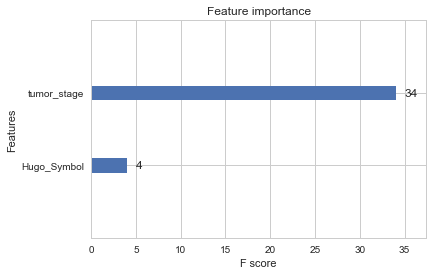

In [399]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [400]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)
y_test_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

The output is not all 0s! This is important to note as the test data is heavily skewed to be mostly 0s. 

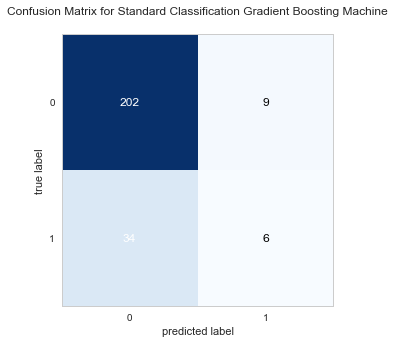

In [401]:
#Confusion Matrix
gbmloss = confusion_matrix(y_test, y_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=gbmloss ,  figsize=(5, 5))
plt.title('Confusion Matrix for Standard Classification Gradient Boosting Machine')
plt.show()

These are the statistics for the Standard Classification GBM
True Positive Rate: 15.0%
False Positive Rate: 4.265402843601896%
Recall/Sensitivity: 15.0%
Precision: 40.0%
Specificity: 95.73459715639811%
Accuracy: 82.86852589641434%
F1 Score: 21.818181818181813%


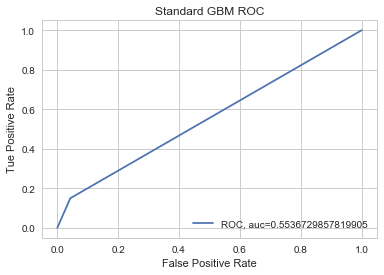

In [402]:
print('These are the statistics for the Standard Classification GBM')
statmaker(gbmloss, 'Standard GBM', y_test_pred, y_test)

The recall, precision, and F1 scores of this model is extremely low. That means that it is a poor classifier of patient survival status based on their gene mutation and tumor stage. The accuracy is high, but that may just be because our model predicted mostly 0s (or patient being alive). Our dataset is heavily skewed towards being 0 for vital_status, so the accuracy score doesn't tell us if the model is a goood classifier. This suggests two things:

1) Clinical data needs to be more balanced for use in machine learning so as to not have skewed data for training purposes

2) More data points are required in clinical data files for use in machine learning.


Now, onto using the survival:cox objective, which will provide us with a survival regression based result. 

### Balancing 'vital_status' to make Balanced Dataset

Given the terrible results of the gradient boosting machine shown above, I have decided to sample the dataset to get equal amounts of vital_status of 0 and 1. Thus, the dataset will be completely balanced regarding patient vital_status.

In [277]:
res1 = res[res['vital_status'] == 1] #Given that 1 appears far less often, I will use the number of 'vital_status' = 1 as data length
res1len = len(res1)
res1len

107

In [278]:
res0 = res[res['vital_status'] ==0] #sample randomly 107 samples from all 'vital_status' =0
res0 = res0.sample(n=res1len)

In [279]:
equals = [res1, res0]
res_new = pd.concat(equals)
res_new = res_new.sample(frac=1)
res_new.head() #combine and shuffle dataframe

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol
43046,a824b3bd-34d5-4cc1-a92f-f9d6ac0f1814,1,385,8,2
3817,38a631a1-6875-4216-a335-ee93c90a86d6,1,302,8,1
1344,878f975b-94fd-4d69-b7e7-1ed3ac2ee438,0,-652,2,2
63246,93ed6066-b567-4e1c-ab81-23370f9d3452,0,-777,5,0
46830,1111fb30-46ce-4722-98da-ec9ba2323d90,1,2483,5,1


### Gradient Boosting Machine with Balanced Dataset

In [388]:
'''Redoing Gradient Boosting Machine with balanced dataset'''

X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

In [389]:
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=100)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=100, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[20:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

In [390]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
best_iter

0

This further proves that the tumor_stage is more important in determining patient survival than the gene mutation at hand.

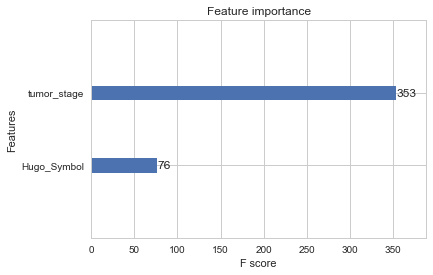

In [391]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [392]:
#Let's do a prediction
y_test_pred_e = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred_e.argmax(axis=0)
y_test_pred_e

array([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 0.], dtype=float32)

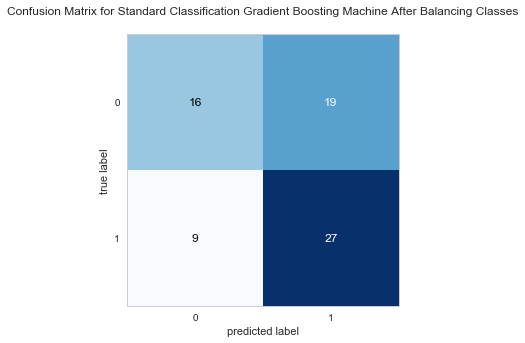

In [393]:
#Confusion Matrix
gbmloss_e = confusion_matrix(y_test, y_test_pred_e)
fig, ax = plot_confusion_matrix(conf_mat=gbmloss_e ,  figsize=(5, 5))
plt.title('Confusion Matrix for Standard Classification Gradient Boosting Machine After Balancing Classes')
plt.show()

These are the statistics for the Standard Classification GBM After Balancing Classes
True Positive Rate: 75.0%
False Positive Rate: 54.285714285714285%
Recall/Sensitivity: 75.0%
Precision: 58.69565217391305%
Specificity: 45.714285714285715%
Accuracy: 60.56338028169014%
F1 Score: 65.85365853658539%


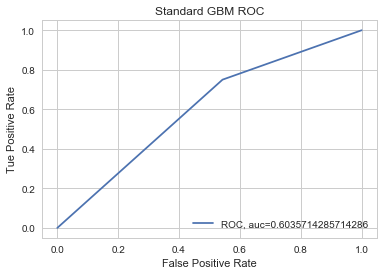

In [394]:
print('These are the statistics for the Standard Classification GBM After Balancing Classes')
statmaker(gbmloss_e, 'Standard GBM', y_test_pred_e, y_test)

##### Success! 

After balancing the dataset, it is clear that the F1 Score, Recall, and Precision shot up. This suggests that the gradient boosting machine's low performance was in part due to the unbalanced dataset that was being used to train it. The AUC value also went up, suggesting that the model became a better classifier than before with fewer datapoints. Notice that the accuracy went down compared to before even though this new gradient boosting machine model is a better classifier. This suggests that accuracy alone is not a good metric for the evaluation of binary classification machine learning algorithms.

The model performance can definitely be improved with the use of more datapoints. Thus, it is important to gather thousands of data points to train such a model before putting it into clinical use. Regardless, these results are promising regarding the use of GBM for breast cancer survival status prediction.

##### COX Regression Based Classification

The COX Regression Objective allows us to make classication based on survival time ('duration' in our case). Thus, now we can use the modified 'duration' column to also make predictions. The result of the following model won't be useful clinically as it requires patient survival times, but it does assess how well one can determine patient survival status based on duration/survival time.

In [403]:
#Need to add duration column for COX Regression based classification
X = res[['Hugo_Symbol', 'tumor_stage', 'duration']]
y = res[['vital_status']]
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35) 


#Here, we apply the gradient boosted model

# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 3,
    "objective": "survival:cox",
    "eval_metric": "logloss",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[20:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

As expected for COX Regression based classification, duration is by far the most important feature for predictions. However, we can see here that the importance of which gene is mutated in a patient is much closer to that of the tumor stage than it was for the simple classification done earlier. This suggests that when patient survival time is taken into account, the type of mutation a patient has is more important than when not considering survival time.

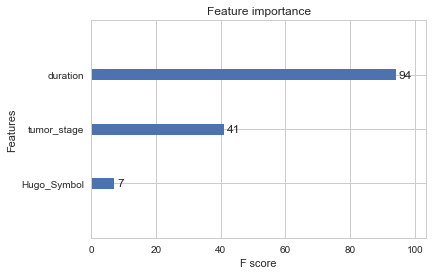

In [404]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [405]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)

In [406]:
#Accuracy of our prediction
print("Accuracy with GBM: ")
a = (y_test_pred_class == y_test).mean()
print(a)

Accuracy with GBM: 
vital_status    0.840637
dtype: float64


As we can see with the survival:cox objective, we got an accuracy of 84%. Thus, our model is very good at determining survival status of patients based on their survival time, mutated gene, and tumor stage. Since patient 'duration' is an end of study feature, including it doesn't really help make patient survival predictive models. 

### MLPClassifier

The MLP Classifier is scikit-learn's own neural network model. It is a good way to determine the number of layers that should be used in the Keras based neural network to be developed after.  

In [408]:
#Need to specify the features to be used again. 
X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']].values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)


In [409]:
#Since I want to determine the best parameters to use for my own neural network after, I will use GridSearch CV on the 
#MLPClassifier for effecient determination of good parameters.

parameters={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(64,2), (32,2), (16,2), (8,2)],
'alpha': 10.0 ** -np.arange(1, 5),
'activation': ["logistic", "relu", "tanh"]
}

nnclf= GridSearchCV(estimator=MLPClassifier(),param_grid=parameters,verbose=2,cv=3)

In [1]:
nnclf.fit(X_train, y_train)                         

In [411]:
print(nnclf.best_params_)

{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (64, 2), 'learning_rate': 'adaptive'}


These are the parameters I will base my Keras based neural network off of. 

In [412]:
y_pred_mlp = nnclf.predict(X_test)
y_pred_mlp

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

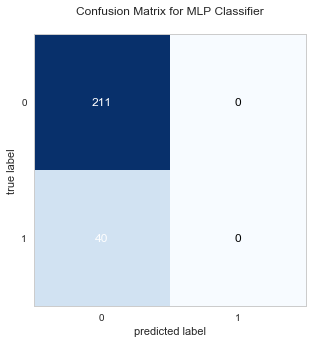

In [416]:
#Confusion Matrix
mlp_cm = confusion_matrix(y_test, y_pred_mlp)
fig, ax = plot_confusion_matrix(conf_mat=mlp_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

These are the statistics for the MLP Classifier
True Positive Rate: 0.0%
False Positive Rate: 0.0%
Recall/Sensitivity: 0.0%
Precision: nan%
Specificity: 100.0%
Accuracy: 84.06374501992032%
F1 Score: nan%


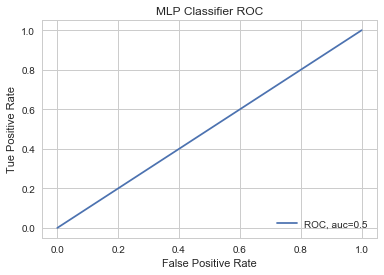

In [417]:
print('These are the statistics for the MLP Classifier')
statmaker(mlp_cm, 'MLP Classifier', y_pred_mlp, y_test)

The MLP Classifier did extremely poorly as it classified every patient in the test set with a 'vital_status' of 0. The F1 score and precision appear nan% because there the true positive and false positive rates are 0%. The accuracy here means nothing except how many matches the classifier got with the test set. This is due to two possible reasons:

1) The skewed dataset as discussed earlier
2) The classifier does poorly on a few number of datapoints. Neural networks work really well on a large number of datapoints. Thus, the few datapoints in this dataset don't allow the MLP Classifier to learn well.

Time to use the balanced data set!

### MLPClassifier with Balanced Dataset

In [418]:
X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

In [419]:
parameters={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(64,2), (32,2), (16,2), (8,2)],
'alpha': 10.0 ** -np.arange(1, 5),
'activation': ["logistic", "relu", "tanh"]
}

nnclf_e= GridSearchCV(estimator=MLPClassifier(),param_grid=parameters,verbose=2,cv=3)

In [8]:
nnclf_e.fit(X_train, y_train)    

In [421]:
print(nnclf_e.best_params_)

{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (8, 2), 'learning_rate': 'adaptive'}


In [422]:
y_pred_mlp_e = nnclf_e.predict(X_test)
y_pred_mlp_e

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0])

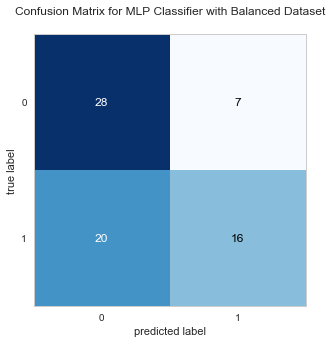

In [423]:
#Confusion Matrix
mlp_e_cm = confusion_matrix(y_test, y_pred_mlp_e)
fig, ax = plot_confusion_matrix(conf_mat=mlp_e_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier with Balanced Dataset')
plt.show()

These are the statistics for the MLP Classifier
True Positive Rate: 44.44444444444444%
False Positive Rate: 20.0%
Recall/Sensitivity: 44.44444444444444%
Precision: 69.56521739130434%
Specificity: 80.0%
Accuracy: 61.97183098591549%
F1 Score: 54.23728813559322%


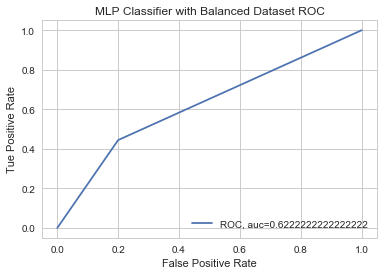

In [424]:
print('These are the statistics for the MLP Classifier')
statmaker(mlp_e_cm, 'MLP Classifier with Balanced Dataset', y_pred_mlp_e, y_test)

##### Success yet again!

The performance of the MLPClassifier went up after using the balanced dataset. The precision is nearing 70%, which is a big turn around from nan% earlier. This is because the model was able to make more correct predictions this time around. This goes to show that the balancing of a dataset can have significant impact on a model's performance. The MLPClassifier is more precise than the GBM model with a balanced dataset, but less sensitive. However, the MLPClassifier has a higher AUC, suggesting that it is better classifier between a patient having a 'vital_status' of 1 or 0 than the GBM.

This model can be improved by using more data points to train. Neural networks perform far better on more data points than was used here. 

Let's now onto the Keras based Neural Network.

### Keras Based Neural Network

Keras is a Python Deep Learning library that will be used to build a neural network. The ideal paramters for this neural network will be based off of the paramters decided by using the MLPClassifier from scikit-learn.

Neural networks are best suited for a large number of data points. Therefore, it may not be ideal here as we are dealing with less than 1000 patients. However, it is still worthwhile to examine the effectiveness of neural networks in analyzing clinical data. If the neural network is able to predict vital status with reasonable accuracy, then it may be useful for analyzing larger number of patients with cancer. 

In [480]:
#We need to convert the labels to categorical labels
from keras.utils import to_categorical

X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']].values.ravel()
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

In [481]:
'''We will be using the Sequential Model with the tanh activation function, a layer of size 64 and a layer of size 2, an 
additional softmax layer, and an adaptive activation function, RMSprop. These choices are based on the GridSearchCV of the 
MLPClassifier without the balanced dataset'''

model = Sequential()
model.add(Dense(64, activation='tanh', input_shape=(2,))) #First layer with 64 units
model.add(Dense(2, activation='tanh')) #Second layer with 2 units, softmax is used 
model.add(Dense(2, activation='softmax')) #Additional layer
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['accuracy'])

print("These are the layers of the model:")
model.summary()

These are the layers of the model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 6         
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [482]:
#Training step
model.fit(
    X, 
    y, 
    batch_size=32, 
    epochs=10, verbose=2, 
    callbacks=None, 
    validation_split=0.33, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0)

Train on 507 samples, validate on 251 samples
Epoch 1/10
 - 0s - loss: 0.5392 - acc: 0.8540 - val_loss: 0.4821 - val_acc: 0.8685
Epoch 2/10
 - 0s - loss: 0.4782 - acc: 0.8540 - val_loss: 0.4529 - val_acc: 0.8685
Epoch 3/10
 - 0s - loss: 0.4588 - acc: 0.8540 - val_loss: 0.4376 - val_acc: 0.8685
Epoch 4/10
 - 0s - loss: 0.4473 - acc: 0.8540 - val_loss: 0.4266 - val_acc: 0.8685
Epoch 5/10
 - 0s - loss: 0.4391 - acc: 0.8540 - val_loss: 0.4181 - val_acc: 0.8685
Epoch 6/10
 - 0s - loss: 0.4328 - acc: 0.8540 - val_loss: 0.4116 - val_acc: 0.8685
Epoch 7/10
 - 0s - loss: 0.4278 - acc: 0.8540 - val_loss: 0.4059 - val_acc: 0.8685
Epoch 8/10
 - 0s - loss: 0.4240 - acc: 0.8540 - val_loss: 0.4019 - val_acc: 0.8685
Epoch 9/10
 - 0s - loss: 0.4214 - acc: 0.8540 - val_loss: 0.3989 - val_acc: 0.8685
Epoch 10/10
 - 0s - loss: 0.4197 - acc: 0.8540 - val_loss: 0.3967 - val_acc: 0.8685


In [483]:
#Make Predictions
y_keras = model.predict_classes(X_test)
y_keras

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

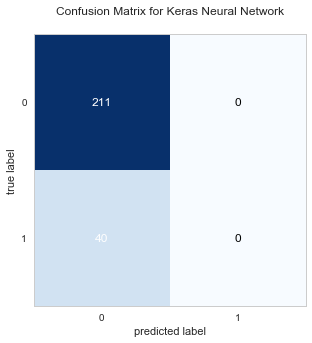

In [484]:
#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y = res[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

#Confusion Matrix
y_keras_cm = confusion_matrix(y_test, y_keras)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network')
plt.show()

These are the statistics for the Keras Neural Network
True Positive Rate: 0.0%
False Positive Rate: 0.0%
Recall/Sensitivity: 0.0%
Precision: nan%
Specificity: 100.0%
Accuracy: 84.06374501992032%
F1 Score: nan%


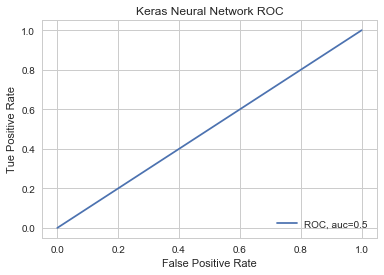

In [485]:
print('These are the statistics for the Keras Neural Network')
statmaker(y_keras_cm, 'Keras Neural Network', y_keras, y_test)

As expected at this point, this model does terrible when it comes to the statistics of value: precision, recall, and F1 score. Similarly to the MLPClassifier, the Keras Neural Network is unable to classify any patient as having a 'vital_status' of 1. This is probably due to the unbalanced test data when it comes to 'vital_status'. Again, accuracy only appears to be so high due to the skew of the test data. Time to use the balanced dataset again!

### Keras Neural Network with Balanced Dataset

In [499]:
X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

In [500]:
modelb = Sequential()
modelb.add(Dense(8, activation='tanh', input_shape=(2,))) #First layer with 8 units
modelb.add(Dense(2, activation='tanh')) #Second layer with 2 units, softmax is used 
modelb.add(Dense(2, activation='softmax')) #Additional layer
modelb.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['accuracy'])

print("These are the layers of the model:")
modelb.summary()

These are the layers of the model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 6         
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [501]:
#Training step
modelb.fit(
    X, 
    y, 
    batch_size=32, 
    epochs=10, verbose=2, 
    callbacks=None, 
    validation_split=0.33, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0)

Train on 143 samples, validate on 71 samples
Epoch 1/10
 - 1s - loss: 0.7889 - acc: 0.5175 - val_loss: 0.7812 - val_acc: 0.4648
Epoch 2/10
 - 0s - loss: 0.7498 - acc: 0.5175 - val_loss: 0.7455 - val_acc: 0.4648
Epoch 3/10
 - 0s - loss: 0.7284 - acc: 0.5175 - val_loss: 0.7232 - val_acc: 0.4648
Epoch 4/10
 - 0s - loss: 0.7143 - acc: 0.4965 - val_loss: 0.7121 - val_acc: 0.4789
Epoch 5/10
 - 0s - loss: 0.7064 - acc: 0.4965 - val_loss: 0.7033 - val_acc: 0.5493
Epoch 6/10
 - 0s - loss: 0.7020 - acc: 0.4755 - val_loss: 0.6953 - val_acc: 0.5775
Epoch 7/10
 - 0s - loss: 0.6978 - acc: 0.5315 - val_loss: 0.6895 - val_acc: 0.5634
Epoch 8/10
 - 0s - loss: 0.6938 - acc: 0.5664 - val_loss: 0.6868 - val_acc: 0.5634
Epoch 9/10
 - 0s - loss: 0.6919 - acc: 0.5594 - val_loss: 0.6865 - val_acc: 0.5634
Epoch 10/10
 - 0s - loss: 0.6905 - acc: 0.5594 - val_loss: 0.6875 - val_acc: 0.5775


In [502]:
#Make Predictions
y_keras_e = modelb.predict_classes(X_test)
y_keras_e

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0], dtype=int64)

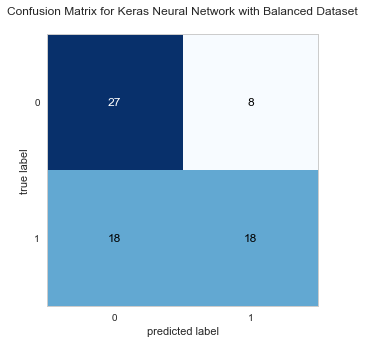

In [505]:
#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y = res_new[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

#Confusion Matrix
y_keras_e_cm = confusion_matrix(y_test, y_keras_e)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_e_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network with Balanced Dataset')
plt.show()

These are the statistics for the Keras Neural Network
True Positive Rate: 50.0%
False Positive Rate: 22.857142857142858%
Recall/Sensitivity: 50.0%
Precision: 69.23076923076923%
Specificity: 77.14285714285715%
Accuracy: 63.38028169014085%
F1 Score: 58.06451612903226%


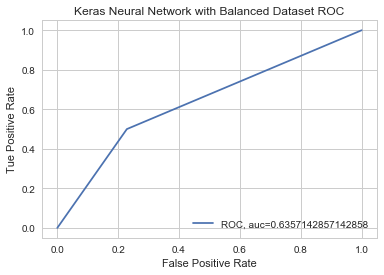

In [506]:
print('These are the statistics for the Keras Neural Network')
statmaker(y_keras_e_cm, 'Keras Neural Network with Balanced Dataset', y_keras_e, y_test)

##### Sucess one last time!

Compared to the Keras Neural Network trained on the unbalanced dataset, this Neural Network obviously performed much better considering the statistics shown. What is more remarkable is that this neural network, which used similar parameters to the MLPClassifier trained on the balanced dataset (plus an extra layer and better optimizer), performed even better than the MLPClassifier trained on the balanced dataset. The MLPClassifier trained on the balanced dataset had a higher AUC score than the GBM trained on the balanced dataset. This neural network has a higher AUC score than both! Thus, it can be said that this classifier is better at classifying patients as having a 'vital_status' of 0 or 1 than all the other models. It has good precision, but 50/50 recall. The recall value ultimately brought down the F1 Score. Regardless, these results once again indicate the importance of training on a balanced, non-skewed dataset. 

Will neural networks be useful in clinical situations? If they are trained on many more data points(thousands to millions), they can be amazing classifiers. Neural networks are often used for image classification in the cinical setting, so their value in patient survival classification may be of great use to clinicians. However, since they are difficult to interpret, clincians may prefer more interpretable approaches.

## Conclusions

The survival analysis portion of this study demonstrated that the HMCN1 gene, although 10th most prevelant amongst the mutated genes prevelant amongst breast cancer patients, may actually be of significant interest to clincians. These mutated gene showed similar cumulative hazard and survival to a point compared to the cumulative hazard and survival of the TP53 and PIK3CA mutations for breast cancer patients. Thus, the data-driven analysis in this work verified the same observation regarding HMCN1 made by scientists in the field. This highlights the value of data science in helping uncover or verify findings that ultimately impact patient care. 

The machine learning compononent of this project provided some interesting insights into how data composition can ultimately impact model strength. Three models were made: gradient boosting machine, MLPClassifier, and a neural network. Each of these model's performances vastly improved after balancing the dataset. It was found that tumor stage has a higher importance in impacting patient survival than gene mutation did. Although none of the models showed valuable power in classification of patient survival based on gene mutation type and tumor stage, the neural network had the highest AUC. This indicates it is best able to classify patient survival given the limited number of features in the balanced dataset. Using the unbalanced dataset, it was found that the gradient boosting machine had the highest AUC. In a clinical setting, one will not face balanced datasets. However, it is important to train on both balanced and unbalanced datasets for clinical purposes as each kind of dataset offers an idea as to patient survival. Training on a near-balanced dataset is perhaps, therefore, ideal, as such a dataset would capture any tendencies in survival status captured in cancer patient population data. 

## References
[1] Li, G., Guo, X., Chen, M., Tang, L., Jiang, H., Day, J. X., . . . Wang, J. (2018). Prevalence and spectrum of AKT1, PIK3CA, PTEN and TP53 somatic mutations in Chinese breast cancer patients. Plos One, 13(9). doi:10.1371/journal.pone.0203495

[2] Kikutake, C., Yoshihara, M., Sato, T., Saito, D., & Suyama, M. (2018). Intratumor heterogeneity of HMCN1 mutant alleles associated with poor prognosis in patients with breast cancer. Oncotarget, 9(70). doi:10.18632/oncotarget.26071

